## NY Taxi

목표 : 택시 데이터에 나와있는 변수들을 통해 주행 시간 예측하기 (회귀분석 문제)

### 01 . Test 방법 

(RMSLE, Root Mean Squared Logarithmic Error)

$$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$$

- 과대 평가 된 항목보다는 과소평가 된 항목에 패널티를 줌
- 오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높음
- 0에 가까운 값이 나올 수록 정밀도가 높은 값
- 잔차(residual)에 대한 평균에 로그를 씌운 값 - 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기 위해
- 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클 수록 오차가 크다는 의미
- 값이 작을 수록 오류가 적다는 의미를 나타냄

---

### 02. 사용할 머신러닝 알고리즘 

#### 1) Scikit learn

- 파이썬으로 머신러닝할 때 많이 쓰는 알고리즘
- classfication, regression, clustering, dimensionality reduction
- classfication : 타이타닉
- regression : 예측 문제 - randomforest 이용

#### 2) Random forest

- clf = RandomForestClassifier()
- clf.fit(X_train, y_train) # x는 변수들을 행렬화, y는 예측값을 벡터로
- y_pred = clf.predict(X_test)
- clf.score(x_test, y_test) # 행렬, 벡터

**Random forest를 사용하기 위해선 Decision Trees를 알아야 함 **

- T/F로 계속 깊게 파고들어가 나무형태로 나타남 (최적화된 값을 찾음)
- 속도가 빠름, 시각화로 설명하기 편함
- Decision Tree를 여러개를 만들어 성능을 예측하는 것이 Random forest
- Feature를 너무 적게도(underfittin) 너무 많이도(overfitting) 하면 안된다

#### 3) KFold 교차 검증

- Cross Validation(일반화 성능을 측정하기 위해 데이터를 여러번 반복해서 나누고 여러 모델을 학습) 교차 검증 중 하나
- 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정
- 첫번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습
- 나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가
- 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 예측
- 이 과정을 마지막 폴드까지 반복
- 이렇게 훈련세트와 테스트 세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸 것이 정확도

---

### 03. 기본적인 패키지 설치

#### 1) 사용할 패키지

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북안에 그래프를 그리기
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 (ggplot 스타일 사용)
plt.style.use("ggplot")

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams["axes.unicode_minus"] = False

#### 2) 한글 깨짐 방지

In [2]:
import matplotlib.font_manager as fm

print("버전: ", mpl.__version__)
print("설치 위치: ", mpl.__file__)
print("설정 위치: ", mpl.get_configdir())
print("캐시: ", mpl.get_cachedir())

버전:  2.1.2
설치 위치:  /usr/local/lib/python3.6/site-packages/matplotlib/__init__.py
설정 위치:  /Users/jisungin/.matplotlib
캐시:  /Users/jisungin/.matplotlib


---

### 04. 데이터 setting

#### 1) Train data

In [3]:
# train data
train = pd.read_csv("train.csv")
train.shape

(1458644, 11)

#### 2) Test data

In [4]:
# test data
test = pd.read_csv("test.csv")
test.tail()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N


#### 3) Submission data

In [5]:
# submission form data
submission = pd.read_csv("sample_submission.csv")
submission.tail()

,id,trip_duration
625129,id3008929,959
625130,id3700764,959
625131,id2568735,959
625132,id1384355,959
625133,id0621643,959


---

### 05. Train data로 EDA (Exploratory Data Analysis) 실행

In [6]:
train.shape # 1,458,644개 데이터, 11개의 컬럼으로 구성

(1458644, 11)

In [7]:
# train.colums
# train.dtypes
train.info() # 데이터에 대한 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
# 최대, 최소, 평균 등 기술통계학 자료, 범주형 자료엔 의미 없음 (object 자료 제외)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


In [9]:
train.tail() # trip_duration이 예측해야 할 column

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.98,40.78,-73.97,40.79,N,198


---

### 06. 새로운 변수 생성

#### 1) store_and_fwd_flag 숫자로 변환 (Y:1, N:0)

In [10]:
train['store_and_fwd_flag'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)

#### 2) distance 생성

(1) 택시를 어디서 주로 탑승할까?

In [11]:
from ipyleaflet import *
import time
center = [40.7830603, -73.9712488] # [위도, 경도]
zoom = 15
m = Map(center = center, zoom = zoom)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[40.7830603, -73.9712488], default_tiles=TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']), layers=(TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']),), layout=Layout(align_self='stretch', height='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=15)

In [12]:
# 지도 중심에 Marker 표시
marker = Marker(location=center)
m += marker

In [13]:
# sample data 생성
train['pickup'] = list(zip(train['pickup_latitude'], train['pickup_longitude']))
pickup_sample = list(train['pickup'][0:50]) 

In [14]:
# 어디서 많이 타는지 Marker 표시
locs = pickup_sample
for loc in locs:
    marker = Marker(location=loc)
    m += marker
    time.sleep(0.5)

$\rightarrow$ 주로 Manhattan에서 탑승하고 있음을 확인

(2) 탑승위치와 하차위치를 통해 주행 거리를 파악

In [15]:
# 두 좌표를 통해 거리 측정하는 함수 생성 (단위는 km)
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [16]:
train['dist'] = \
    haversine_np(train['pickup_longitude'], train['pickup_latitude'],
                 train['dropoff_longitude'], train['dropoff_latitude'])

#### 3) speed 생성

In [17]:
# 속력 = 거리 / 시간
# 속력은 거리와 rank가 겹칠 수 있기 때문에 전처리 과정후에 최종 데이터에선 제외할 예정
train['speed'] = train['dist'] / (train['trip_duration']/3600) # 초를 시간으로 바꿔서 속도 구하기 (km/h)

#### 4) 시간 나누기 (월, 요일, 시간별)

In [18]:
# pickup_datetime데이터를 datetime타입으로 변환
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"]) 

In [19]:
nowTime = now.strftime('%H:%M:%S')
print(nowTime)
nowTime = now.strftime('%H:%M:%S')
print(nowTime)

NameError: name 'now' is not defined

In [20]:
train["pickup_datetime"].replace(day=16)

TypeError: replace() got an unexpected keyword argument 'day'

(1) month (월)

In [21]:
# month 데이터 생성
train["month"] = train["pickup_datetime"].dt.month

(2) dayofweek (요일)

In [22]:
# month 데이터 생성
train["dayofweek"] = train["pickup_datetime"].dt.weekday

(3) hour (시간)

In [23]:
# hour 데이터 생성
train["hour"] = train["pickup_datetime"].dt.hour

#### 5) EDA를 위한 count 생성

In [24]:
# count = 1
train["count"] = 1

#### 6) 최종 데이터

In [25]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dist,speed,month,dayofweek,hour,count
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,455,"(40.76793670654297, -73.98215484619139)",1.50,11.85,3,0,17,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,663,"(40.738563537597656, -73.98041534423827)",1.80,9.80,6,6,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,2124,"(40.763938903808594, -73.97902679443358)",6.38,10.82,1,1,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,429,"(40.719970703125, -74.01004028320312)",1.48,12.46,4,2,19,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,435,"(40.79320907592773, -73.97305297851562)",1.19,9.83,3,5,13,1


In [26]:
train.to_csv("modify.csv", index = False)

In [27]:
weather = pd.read_csv("weather.csv")
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.00,0.00,0.0,0
1,2-1-2016,40,32,36.00,0.00,0.0,0
2,3-1-2016,45,35,40.00,0.00,0.0,0
3,4-1-2016,36,14,25.00,0.00,0.0,0
4,5-1-2016,29,11,20.00,0.00,0.0,0


In [28]:
weather["date"] = pd.to_datetime(weather["date"]) 

In [29]:
weather.tail()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
361,2016-12-27,60,40,50.00,0,0,0
362,2016-12-28,40,34,37.00,0,0,0
363,2016-12-29,46,33,39.50,0.39,0,0
364,2016-12-30,40,33,36.50,0.01,T,0
365,2016-12-31,44,31,37.50,0,0,0


In [30]:
weather1 = pd.read_csv("weather1.csv")
weather1.tail()

,pickup_datetime,tempm,tempi,dewptm,dewpti,hum,wspdm,wspdi,wgustm,wgusti,...,precipm,precipi,conds,icon,fog,rain,snow,hail,thunder,tornado
10476,2016-12-31 19:51:00,6.10,43.00,-4.40,24.10,47.00,7.40,4.60,nan,nan,...,nan,nan,Overcast,cloudy,0,0,0,0,0,0
10477,2016-12-31 20:51:00,6.10,43.00,-4.40,24.10,47.00,13.00,8.10,38.90,24.20,...,nan,nan,Overcast,cloudy,0,0,0,0,0,0
10478,2016-12-31 21:51:00,6.10,43.00,-5.00,23.00,45.00,9.30,5.80,29.60,18.40,...,nan,nan,Overcast,cloudy,0,0,0,0,0,0
10479,2016-12-31 22:51:00,6.70,44.10,-5.00,23.00,43.00,14.80,9.20,nan,nan,...,nan,nan,Overcast,cloudy,0,0,0,0,0,0
10480,2016-12-31 23:51:00,6.70,44.10,-4.40,24.10,45.00,7.40,4.60,25.90,16.10,...,nan,nan,Overcast,cloudy,0,0,0,0,0,0


---

### 07. EDA 실행 (기본)

- 전체적으로 살펴보기
- 각 변수별 EDA

#### 1) 전체적으로 살펴보기

In [25]:
# 총 17개 변수 생성
train.shape

(1458644, 18)

In [26]:
# 새로 추가한 변수들 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int64
trip_duration         1458644 non-null int64
pickup                1458644 non-null object
dist                  1458644 non-null float64
speed                 1458644 non-null float64
month                 1458644 non-null int64
dayofweek             1458644 non-null int64
hour                  1458644 non-null int64
count                 1458644 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(8), obje

In [27]:
# null 값이 있는지 없는지 확인
train.isnull().sum() 

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup                0
dist                  0
speed                 0
month                 0
dayofweek             0
hour                  0
count                 0
dtype: int64

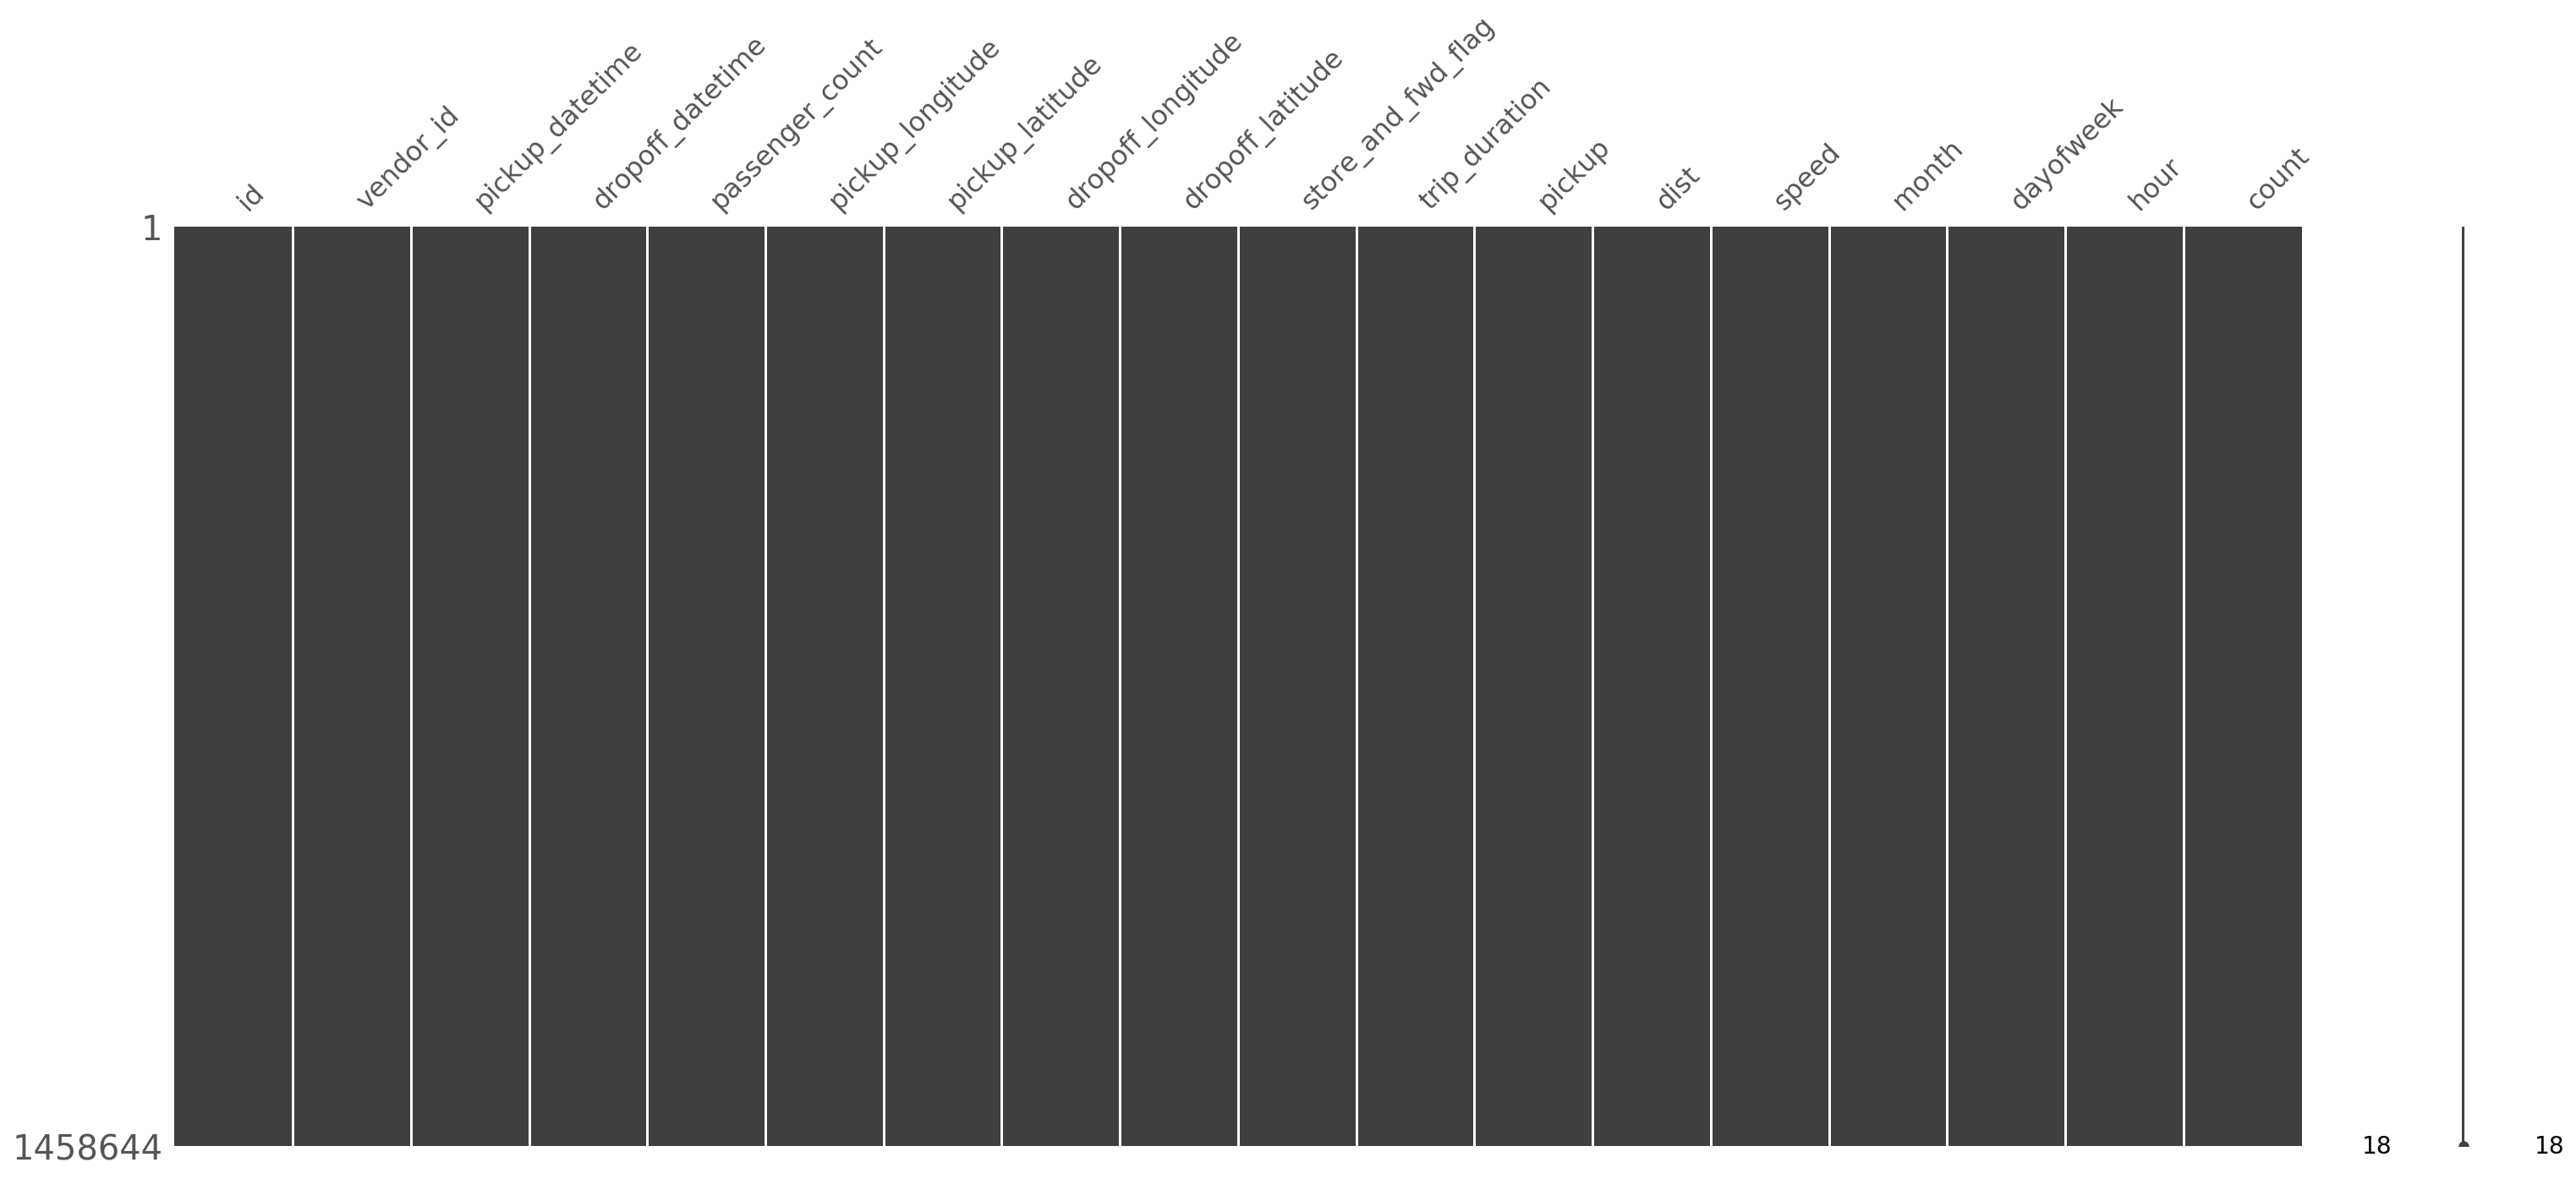

In [28]:
# null값 시각화
import missingno as msno
msno.matrix(train)
plt.show()

#### 2) 각 변수별 EDA

1) vendor_id

In [29]:
vendor = pd.DataFrame(train, columns=["vendor_id"])
vendor = train.groupby(["vendor_id"]).size().reset_index(name='Counts')
vendor

,vendor_id,Counts
0,1,678342
1,2,780302


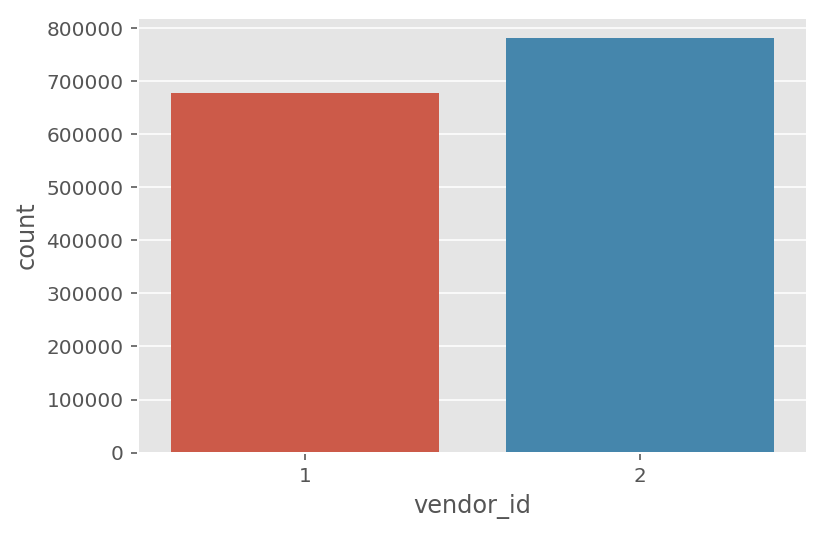

In [30]:
sns.countplot(x = 'vendor_id', data = train)
plt.show()

$\rightarrow$ vendor_id 중 2가 더 많음

2) passenger_count

In [31]:
passenger = pd.DataFrame(train, columns=["passenger_count"])
passenger = train.groupby(["passenger_count"]).size().reset_index(name='Counts')
passenger

,passenger_count,Counts
0,0,60
1,1,1033540
2,2,210318
3,3,59896
4,4,28404
5,5,78088
6,6,48333
7,7,3
8,8,1
9,9,1


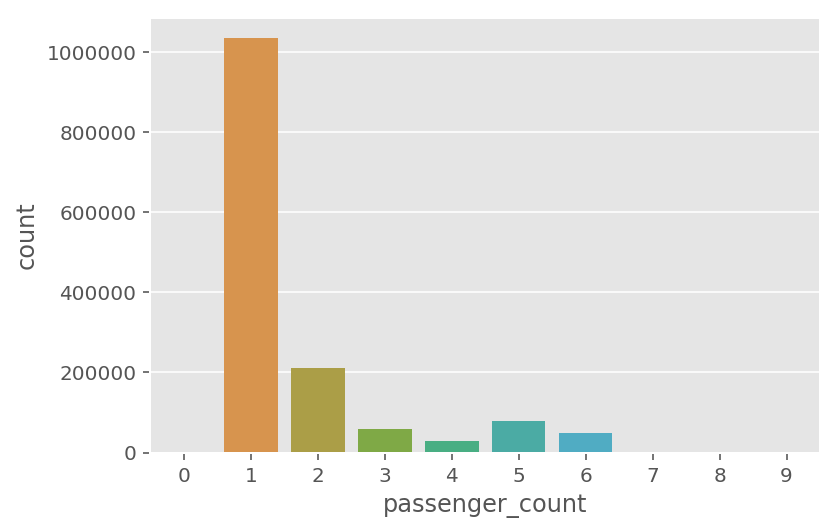

In [32]:
sns.countplot(x = 'passenger_count', data = train)
plt.show()

$\rightarrow$ 승객수는 1명이 제일 많음, 승객이 없거나 7명 이상은 오류라 판단

3) sotre_and_fwd_flag

In [33]:
store = pd.DataFrame(train, columns=["store_and_fwd_flag"])
store = train.groupby(["store_and_fwd_flag"]).size().reset_index(name='Counts')
store

,store_and_fwd_flag,Counts
0,0,1450599
1,1,8045


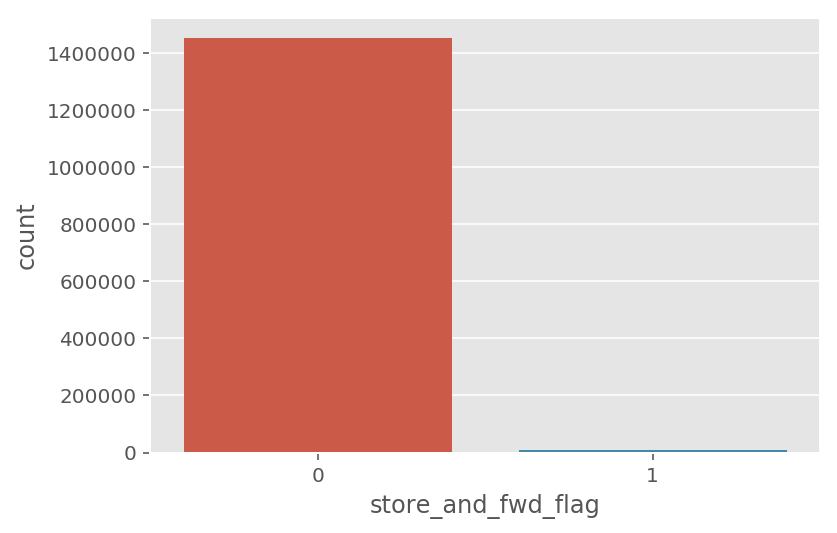

In [34]:
sns.countplot(x = 'store_and_fwd_flag', data = train)
plt.show()

$\rightarrow$ store_and_fwd_flag 중 0이 압도적으로 높은데 이 변수는 활용 가능한건가?

4) dist (logitude,latitude이용)

In [35]:
train["dist"].describe()

count   1458644.00
mean          3.44
std           4.29
min           0.00
25%           1.23
50%           2.09
75%           3.87
max        1240.13
Name: dist, dtype: float64

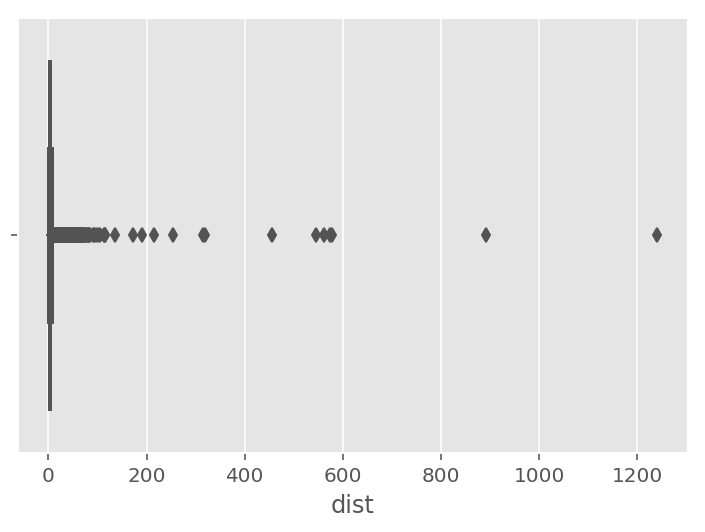

In [36]:
sns.boxplot(x = 'dist', data = train)
plt.show()

$\rightarrow$ dist가 0인 경우, 200,300km 이상은 오류라 판단됨

5) speed

In [37]:
train["speed"].describe()

count   1458644.00
mean         14.41
std          14.97
min           0.00
25%           9.12
50%          12.78
75%          17.83
max        9269.01
Name: speed, dtype: float64

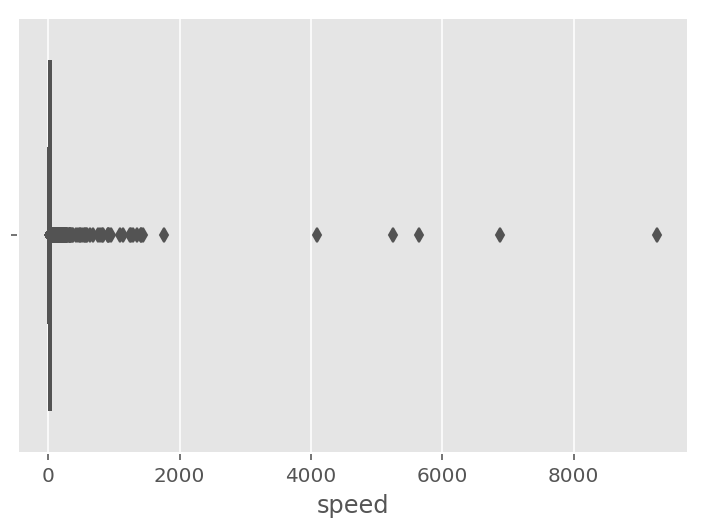

In [38]:
sns.boxplot(x = 'speed', data = train)
plt.show()

$\rightarrow$ 속도가 0이거나 200km/h 이상은 사실상 오류라고 판단

6) month (1~6)

In [39]:
taxi_month = pd.DataFrame(train, columns=["month"])
taxi_month = train.groupby(["month"]).size().reset_index(name='Counts')
taxi_month

,month,Counts
0,1,229707
1,2,238300
2,3,256189
3,4,251645
4,5,248487
5,6,234316


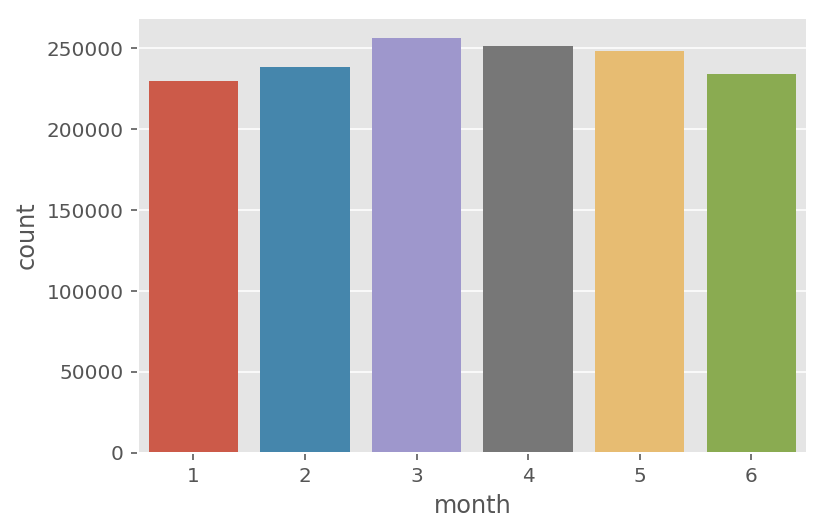

In [40]:
sns.countplot(x = 'month', data = train)
plt.show()

$\rightarrow$ 대체적으로 고른 분포를 보이는 것으로 판단됨

7) dayofweek (0~6)

In [41]:
dayofweek = pd.DataFrame(train, columns=["dayofweek"])
dayofweek = train.groupby(["dayofweek"]).size().reset_index(name='Counts')
dayofweek # 0-월 1-화 2-수 3-목 4-금 5-토 6-일

,dayofweek,Counts
0,0,187418
1,1,202749
2,2,210136
3,3,218574
4,4,223533
5,5,220868
6,6,195366


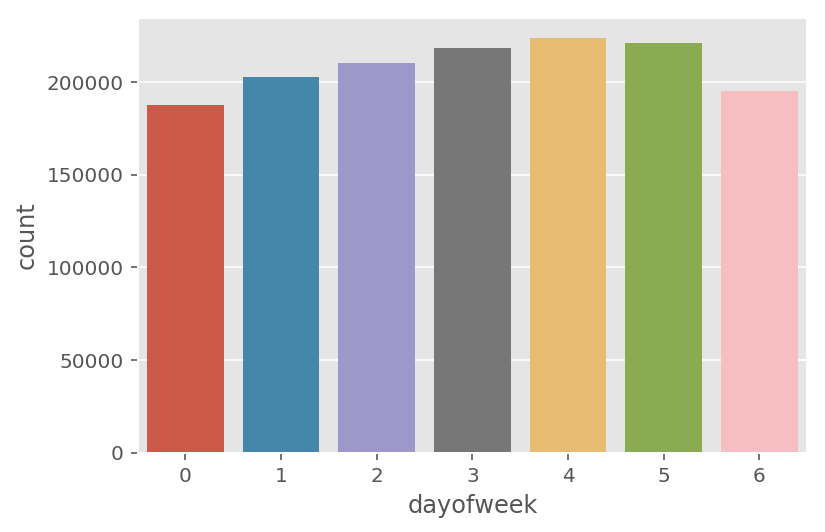

In [42]:
sns.countplot(x = 'dayofweek', data = train)
plt.show()

$\rightarrow$ 금요일이 이용횟수가 제일 많고 월요일이 낮음

8) hour (00~23)

In [43]:
hour = pd.DataFrame(train, columns=["hour"])
hour = train.groupby(["hour"]).size().reset_index(name='counts')
hour

,hour,counts
0,0,53248
1,1,38571
2,2,27972
3,3,20895
4,4,15792
5,5,15002
6,6,33248
7,7,55600
8,8,67053
9,9,67663


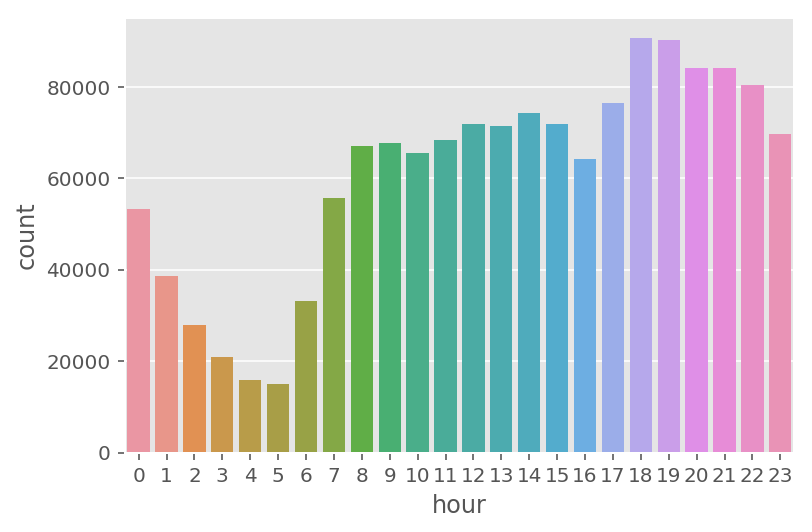

In [44]:
sns.countplot(x = 'hour', data = train)
plt.show()

$\rightarrow$ 시간은 새벽시간대가 이용횟수가 가장 낮았으며 저녁시간대 이용 횟수가 높다는 것을 확인

9) trip_duration

In [45]:
train["trip_duration"].describe()

count   1458644.00
mean        959.49
std        5237.43
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

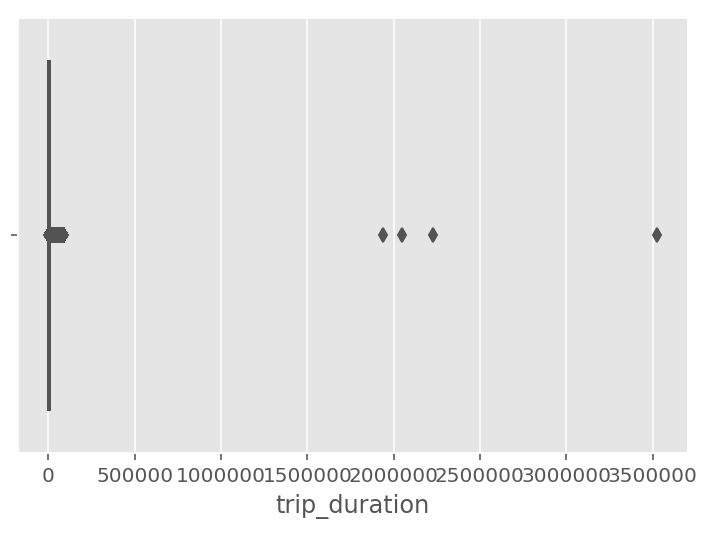

In [46]:
sns.boxplot(x = 'trip_duration', data = train)
plt.show()

$\rightarrow$ 이용시간이 너무 적은건 오류라 판단, 이용시간이 150,000초(약 41시간)동안 택시를 탄다는건 오류라 판단

---

### 08. Proceeding (전처리)

- 앞에서 확인한 EDA를 통해 이상값들을 제거

#### 1) passenger_count 정리 - 0명, 7명 이상 제거

In [31]:
train = train[train['passenger_count'] > 0].reset_index(drop=True)
train = train[train['passenger_count'] < 7].reset_index(drop=True)

#### 2) dist 정리 - 700m 이하, 100km 이상 제거

In [32]:
train = train[train['dist'] > 0.7].reset_index(drop=True)
train = train[train['dist'] < 100].reset_index(drop=True)

#### 3) speed 정리 - 5km/h 이하 , 200km/h 이상 제거

In [33]:
train = train[train['speed'] > 5].reset_index(drop=True)
train = train[train['speed'] < 150].reset_index(drop=True)

#### 4) trip_duration - 1분 이하, 3시간 이상 제거

In [34]:
train = train[train['trip_duration'] > 60].reset_index(drop=True)
train = train[train['trip_duration'] < 10800].reset_index(drop=True)

In [35]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist,speed,month,dayofweek,hour,count
count,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00,1310322.00
mean,1.53,1.67,-73.97,40.75,-73.97,40.75,0.01,868.92,3.74,15.13,3.51,3.06,13.63,1.00
std,0.50,1.31,0.04,0.03,0.04,0.03,0.07,654.28,4.03,7.52,1.68,1.96,6.47,0.00
min,1.00,1.00,-74.73,40.10,-74.78,40.15,0.00,61.00,0.70,5.00,1.00,0.00,0.00,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,0.00,433.00,1.43,9.84,2.00,1.00,9.00,1.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,0.00,689.00,2.32,13.38,4.00,3.00,14.00,1.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,0.00,1097.00,4.21,18.40,5.00,5.00,19.00,1.00
max,2.00,6.00,-73.24,41.32,-72.72,41.48,1.00,10704.00,97.52,146.19,6.00,6.00,23.00,1.00


총 148,322개 데이터 제거

In [36]:
train.to_csv("modify1.csv", index = False)

### 09. EDA 다시 실행 (전처리 후)

- 각 변수와 trip_duration간 EDA
- 여러 변수와 trip_duration간 EDA
- 상관관계

#### 1) 각 변수와 trip_duration간 EDA (1:1)

(1) Vendor

In [52]:
#pivot table 생성
vendor = train.pivot_table(values="trip_duration",columns="vendor_id", aggfunc=np.mean)
vendor

vendor_id,1,2
trip_duration,863.71,873.47


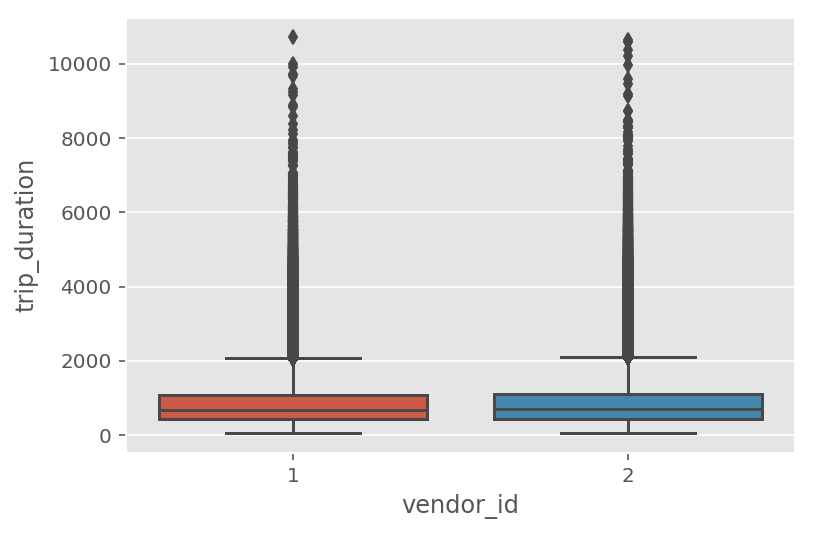

In [53]:
# vendor_id별 boxplot
sns.boxplot(x="vendor_id", y="trip_duration", data=train)
plt.show()

(2) passenger_count

In [54]:
#pivot table 생성
passenger = train.pivot_table(values="trip_duration",columns="passenger_count", aggfunc=np.mean)
passenger

passenger_count,1,2,3,4,5,6
trip_duration,857.69,908.28,894.71,920.33,874.22,865.83


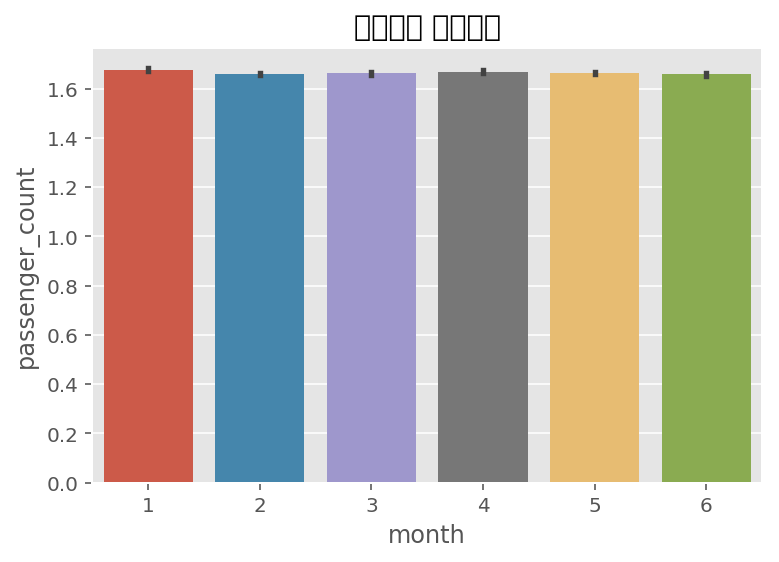

In [55]:
# barplot으로 표현
sns.barplot(data = train, x = 'month', y = 'passenger_count')

xlabel = "passenger_count"
ylabel = "tripduration"

plt.title('승객수별 탑승시간')
plt.show()

(3) store_and_fwd_flag

In [56]:
#pivot table 생성
store_and_fwd_flag = train.pivot_table(values="trip_duration",columns=["store_and_fwd_flag"], aggfunc=np.mean)
store_and_fwd_flag

store_and_fwd_flag,0,1
trip_duration,867.42,1137.73


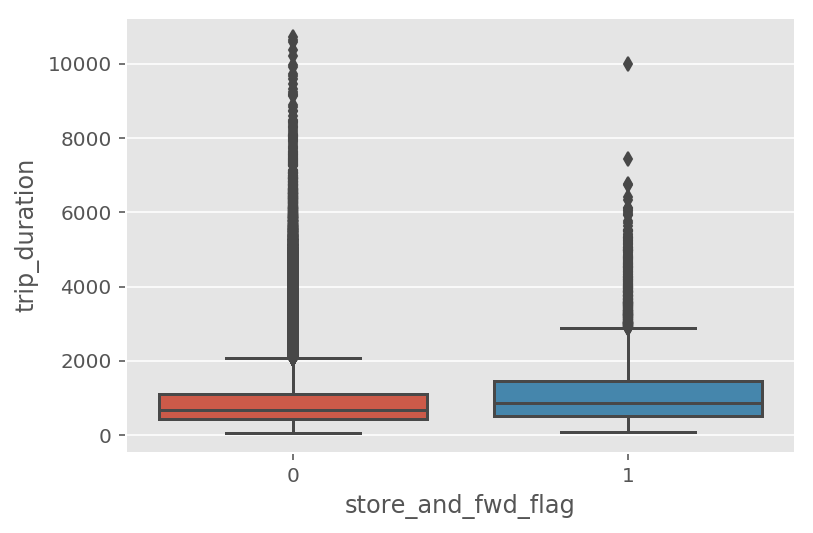

In [57]:
# store_and_fwd_flag별 boxplot
sns.boxplot(x="store_and_fwd_flag", y="trip_duration", data=train)
plt.show()

(4) dist

In [58]:
train["dist"].describe()

count   1310322.00
mean          3.74
std           4.03
min           0.70
25%           1.43
50%           2.32
75%           4.21
max          97.52
Name: dist, dtype: float64

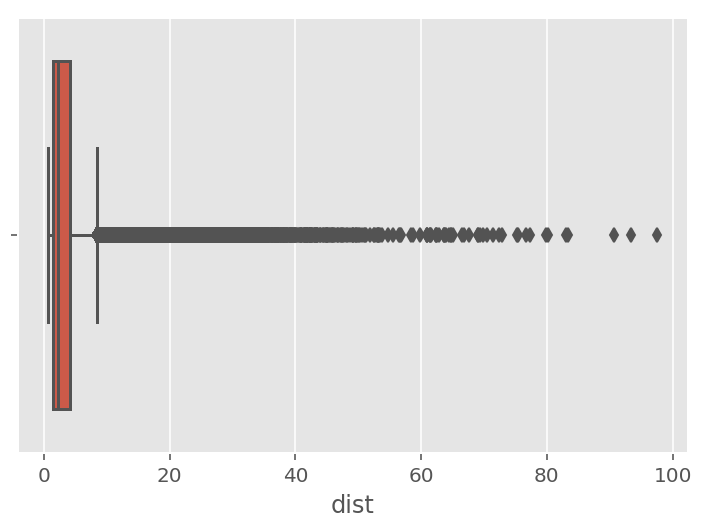

In [59]:
sns.boxplot(x = 'dist', data = train)
plt.show()

(5) speed

In [60]:
train["speed"].describe()

count   1310322.00
mean         15.13
std           7.52
min           5.00
25%           9.84
50%          13.38
75%          18.40
max         146.19
Name: speed, dtype: float64

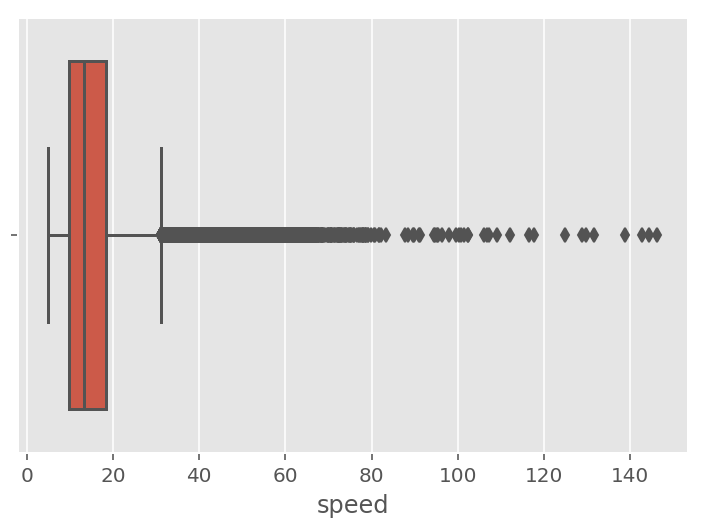

In [61]:
sns.boxplot(x = 'speed', data = train)
plt.show()

(6) 월별 trip_duration

In [62]:
#pivot table 생성
month = train.pivot_table(values="trip_duration",columns=["month"], aggfunc=np.mean)
month

month,1,2,3,4,5,6
trip_duration,821.88,824.44,849.60,881.16,915.28,920.01


In [63]:
# 최대, 최소 시간대 구하기
print("최대 탑승시간 월: {}월 , 값: {}초".format(np.argmax(month.iloc[:, ].values)+1, round(np.nanmax(month.iloc[:, ].values), 2)))
print("최소 탑승시간 월: {}월 , 값: {}초".format(np.argmin(month.iloc[:, ].values)+1, round(np.nanmin(month.iloc[:, ].values), 2)))

최대 탑승시간 월: 6월 , 값: 920.01초
최소 탑승시간 월: 1월 , 값: 821.88초


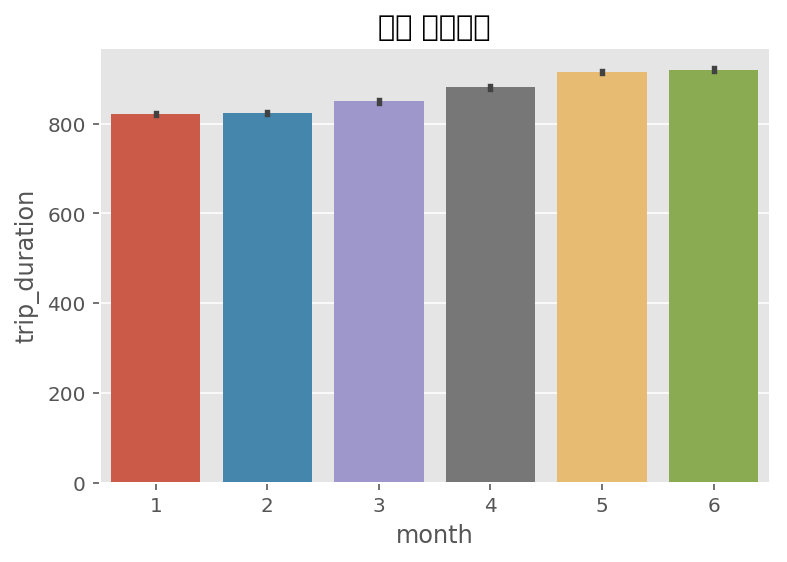

In [64]:
# barplot으로 표현
sns.barplot(data = train, x = 'month', y = 'trip_duration')

xlabel = "month"
ylabel = "tripduration"

plt.title('월별 탑승시간')
plt.show()

(7) 요일 별 trip_duration

In [65]:
#pivot table 생성
dayofweek = train.pivot_table(values="trip_duration",columns=["dayofweek"], aggfunc=np.mean)
dayofweek

dayofweek,0,1,2,3,4,5,6
trip_duration,844.76,886.79,909.77,931.74,903.10,809.24,792.21


In [66]:
# 최대, 최소 시간대 구하기
dayofweek = train.pivot_table(values="trip_duration",columns=["dayofweek"], aggfunc=np.mean)
print("최대 탑승시간 요일: {} , 값: {}초".format(np.argmax(dayofweek.iloc[:, ].values)+1, round(np.nanmax(dayofweek.iloc[:, ].values), 2)))
print("최소 탑승시간 요일: {} , 값: {}초".format(np.argmin(dayofweek.iloc[:, ].values)+1, round(np.nanmin(dayofweek.iloc[:, ].values), 2)))

최대 탑승시간 요일: 4 , 값: 931.74초
최소 탑승시간 요일: 7 , 값: 792.21초


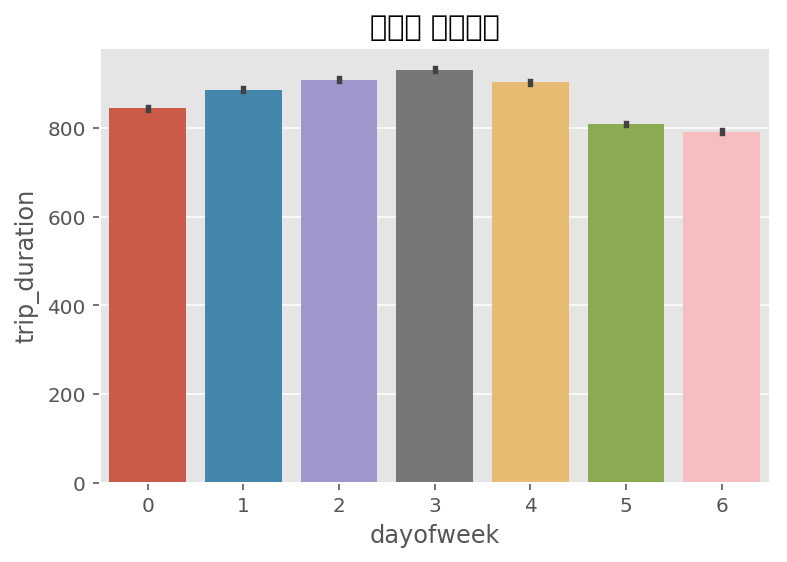

In [67]:
# barplot으로 표현
sns.barplot(data = train, x = 'dayofweek', y = 'trip_duration')

xlabel = "dayofweek"
ylabel = "tripduration"

plt.title('요일별 탑승시간')
plt.show()

(8) 시간 별 trip_duration

In [68]:
#pivot table 생성
hour = train.pivot_table(values="trip_duration",columns=["hour"], aggfunc=np.mean)
hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
trip_duration,813.24,768.23,739.13,740.44,776.58,745.87,699.24,787.52,868.63,873.20,...,990.31,1014.04,1011.42,966.92,895.95,822.84,799.29,805.14,832.00,841.88


In [69]:
# 최대, 최소 시간대 구하기
month = train.pivot_table(values="trip_duration",columns=["hour"], aggfunc=np.mean)
print("최대 탑승시간대: {}시 , 값: {}초".format(np.argmax(hour.iloc[:, ].values), round(np.nanmax(hour.iloc[:, ].values), 2)))
print("최소 탑승시간대: {}시 , 값: {}초".format(np.argmin(hour.iloc[:, ].values), round(np.nanmin(hour.iloc[:, ].values), 2)))

최대 탑승시간대: 15시 , 값: 1014.04초
최소 탑승시간대: 6시 , 값: 699.24초


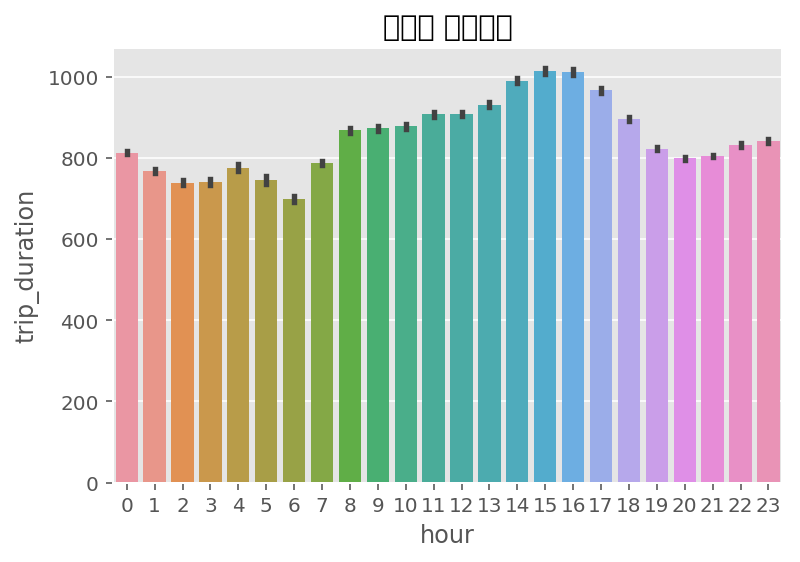

In [70]:
# barplot으로 표현
sns.barplot(data = train, x = 'hour', y = 'trip_duration')

xlabel = "hour"
ylabel = "tripduration"

plt.title('시간별 탑승시간')
plt.show()

#### 2) 여러 변수와 trip_duration간 EDA

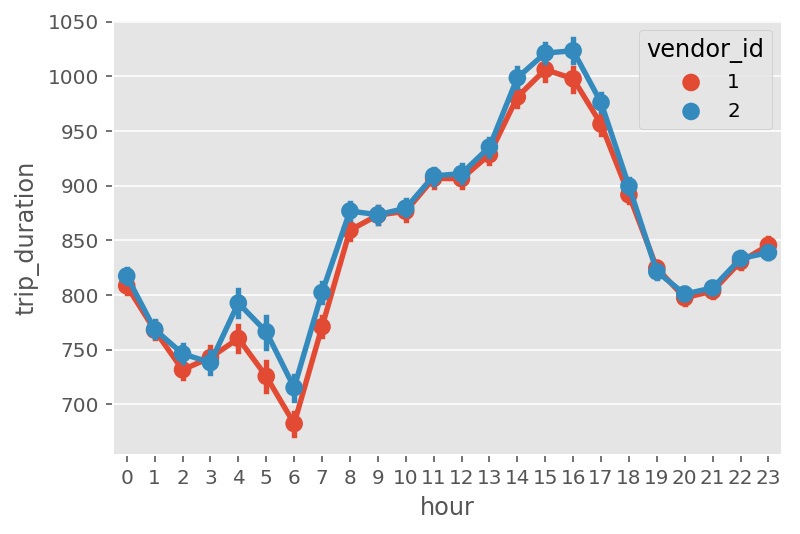

In [71]:
# 시간대별로 각 vendor마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "hour", y = "trip_duration", hue = "vendor_id", ax = ax1)
plt.show()

$\rightarrow$ vendor별로 봤을 때 동일한 흐름을 보임

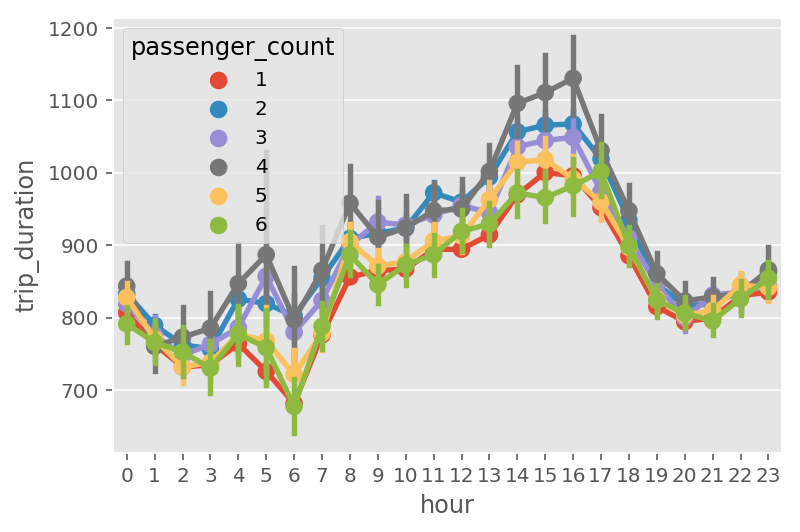

In [73]:
# 시간대별로 각 승객수 마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "hour", y = "trip_duration", hue = "passenger_count", ax = ax1)
plt.show()

$\rightarrow$ 승객수 별로 비슷한 흐름을 보임

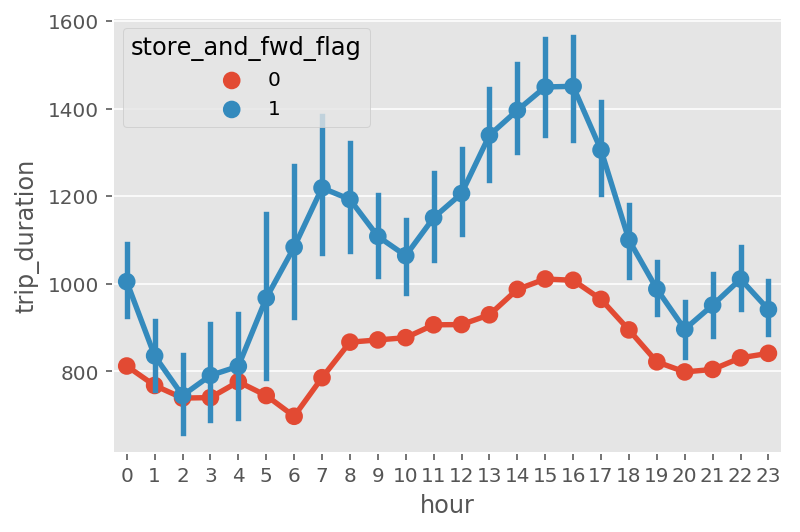

In [74]:
# 시간대별로 각 store_and_fwd_flag마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "hour", y = "trip_duration", hue = "store_and_fwd_flag", ax = ax1)
plt.show()

$\rightarrow$ 전반적으론 비슷한 흐름을 보이지만 store_and_fwd_flag 1이 0보다 큰 값을 가짐

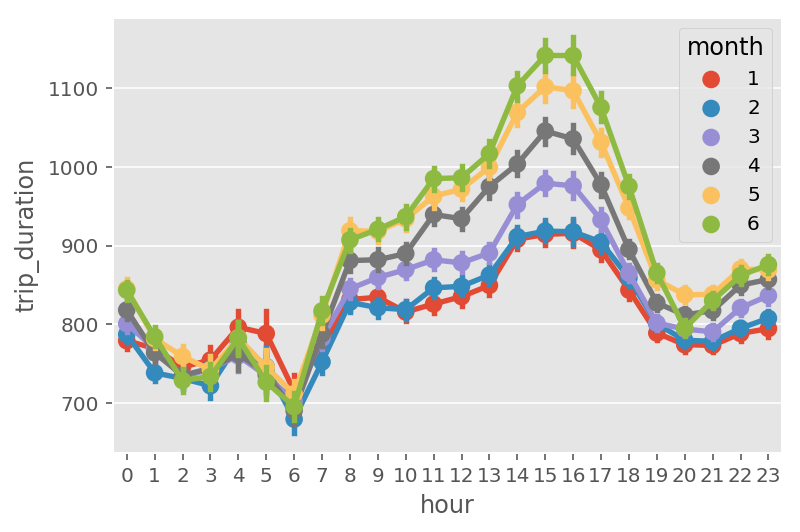

In [76]:
# 시간대별로 각 month마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "hour", y = "trip_duration", hue = "month", ax = ax1)
plt.show()

$\rightarrow$ 오후 시간대는 월이 지날수록 탑승시간이 증가하고 있음을 확인

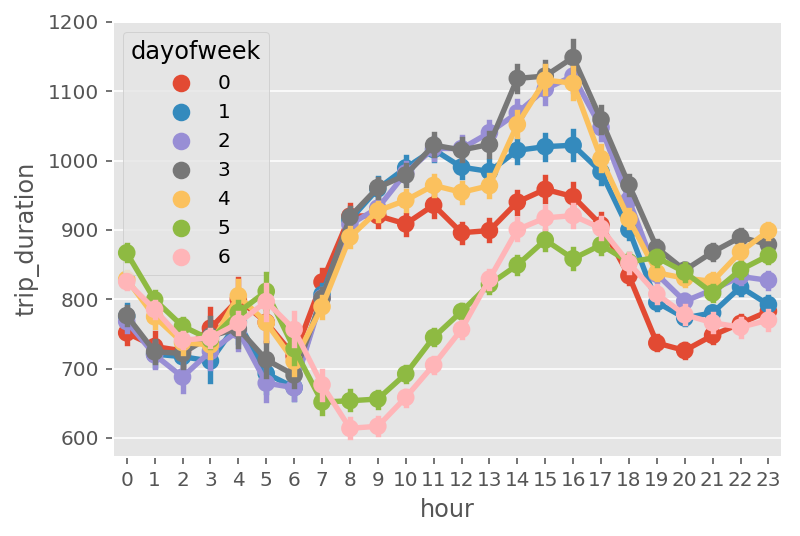

In [77]:
# 시간대별로 각 dayofweek마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "hour", y = "trip_duration", hue = "dayofweek", ax = ax1)
plt.show()

$\rightarrow$ 주말 일수록 오전부터 점심시간까지 택시 이용시간이 현저히 낮아짐을 확인할 수 있음

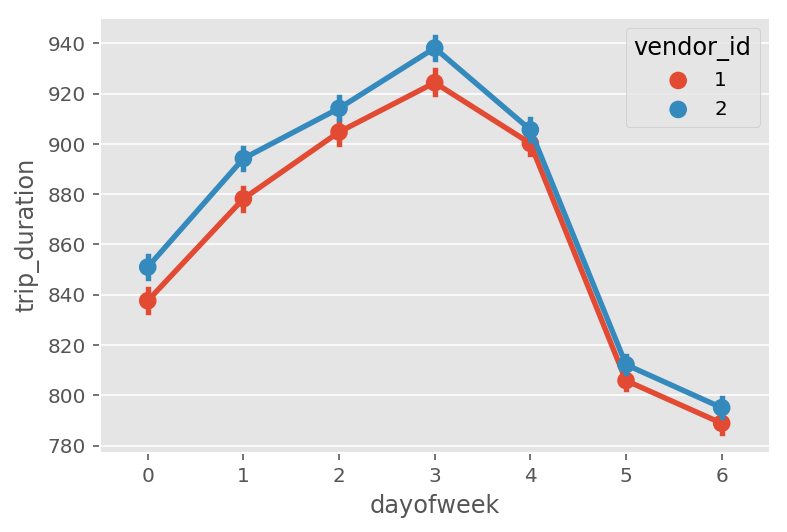

In [78]:
# 요일별로 각 vendor마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "dayofweek", y = "trip_duration", hue = "vendor_id", ax = ax1)
plt.show()

$\rightarrow$ vendor별로 비슷한 흐름을 보임

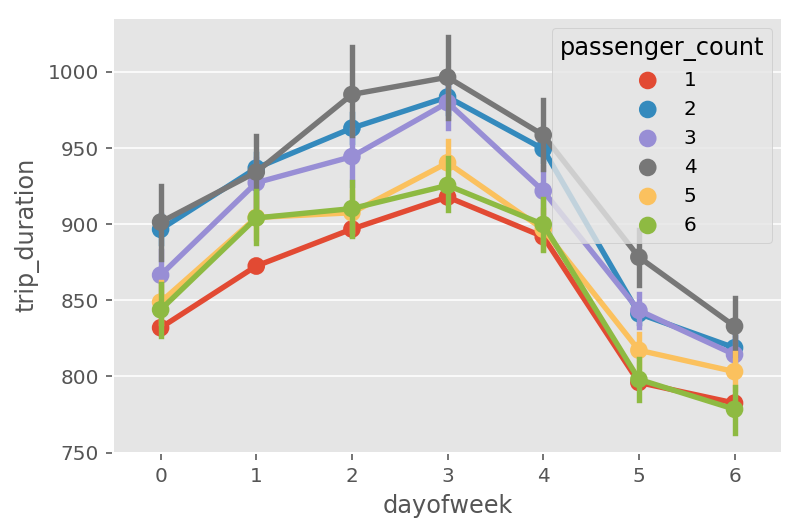

In [79]:
# 요일별로 각 passenger마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "dayofweek", y = "trip_duration", hue = "passenger_count", ax = ax1)
plt.show()

$\rightarrow$ 전반적으로 비슷한 흐름

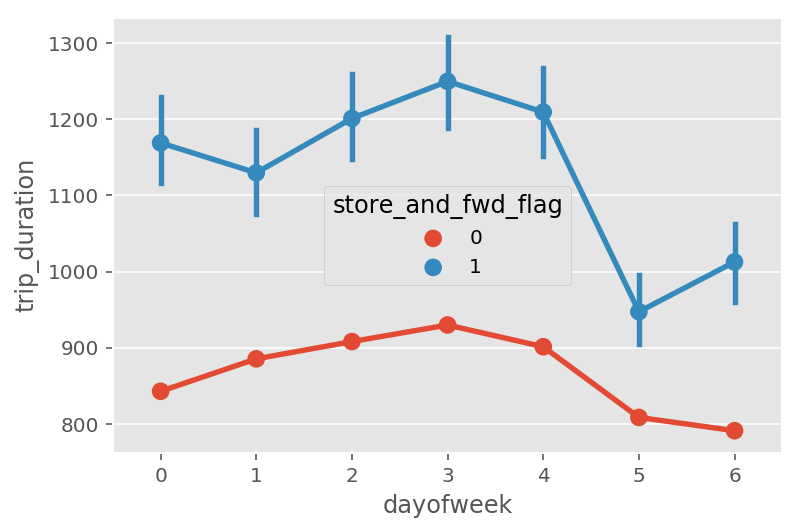

In [80]:
# 요일별로 각 store_and_fwd_flag마다 탑승 시간 구하기
fig, ax1 = plt.subplots(nrows = 1)
sns.pointplot(data = train, x = "dayofweek", y = "trip_duration", hue = "store_and_fwd_flag", ax = ax1)
plt.show()

$\rightarrow$ 월요일~화요일, 토요일~일요일은 반비례하는 관계를 보이는데 무엇을 의미할까?

#### 3) 상관관계 (correlation)

In [81]:
# 변수간 상관관계
corrMatt = train.corr()
corrMatt

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist,speed,month,dayofweek,hour,count
vendor_id,1.00,0.29,0.02,0.00,0.01,0.00,-0.08,0.01,0.01,0.00,-0.01,0.00,0.01,nan
passenger_count,0.29,1.00,0.01,-0.01,0.00,-0.00,-0.02,0.01,0.01,-0.00,-0.00,0.03,0.01,nan
pickup_longitude,0.02,0.01,1.00,-0.16,0.23,0.04,0.02,0.39,0.53,0.31,0.01,-0.03,0.02,nan
pickup_latitude,0.00,-0.01,-0.16,1.00,0.05,0.39,-0.01,-0.25,-0.33,-0.13,-0.00,-0.03,0.01,nan
dropoff_longitude,0.01,0.00,0.23,0.05,1.00,0.13,0.02,0.24,0.38,0.30,0.01,-0.00,-0.05,nan
dropoff_latitude,0.00,-0.00,0.04,0.39,0.13,1.00,-0.01,-0.19,-0.16,0.02,-0.00,-0.02,0.02,nan
store_and_fwd_flag,-0.08,-0.02,0.02,-0.01,0.02,-0.01,1.00,0.03,0.03,0.01,0.00,-0.00,0.00,nan
trip_duration,0.01,0.01,0.39,-0.25,0.24,-0.19,0.03,1.00,0.79,0.06,0.06,-0.04,0.03,nan
dist,0.01,0.01,0.53,-0.33,0.38,-0.16,0.03,0.79,1.00,0.56,0.02,0.00,-0.02,nan
speed,0.00,-0.00,0.31,-0.13,0.30,0.02,0.01,0.06,0.56,1.00,-0.03,0.07,-0.12,nan


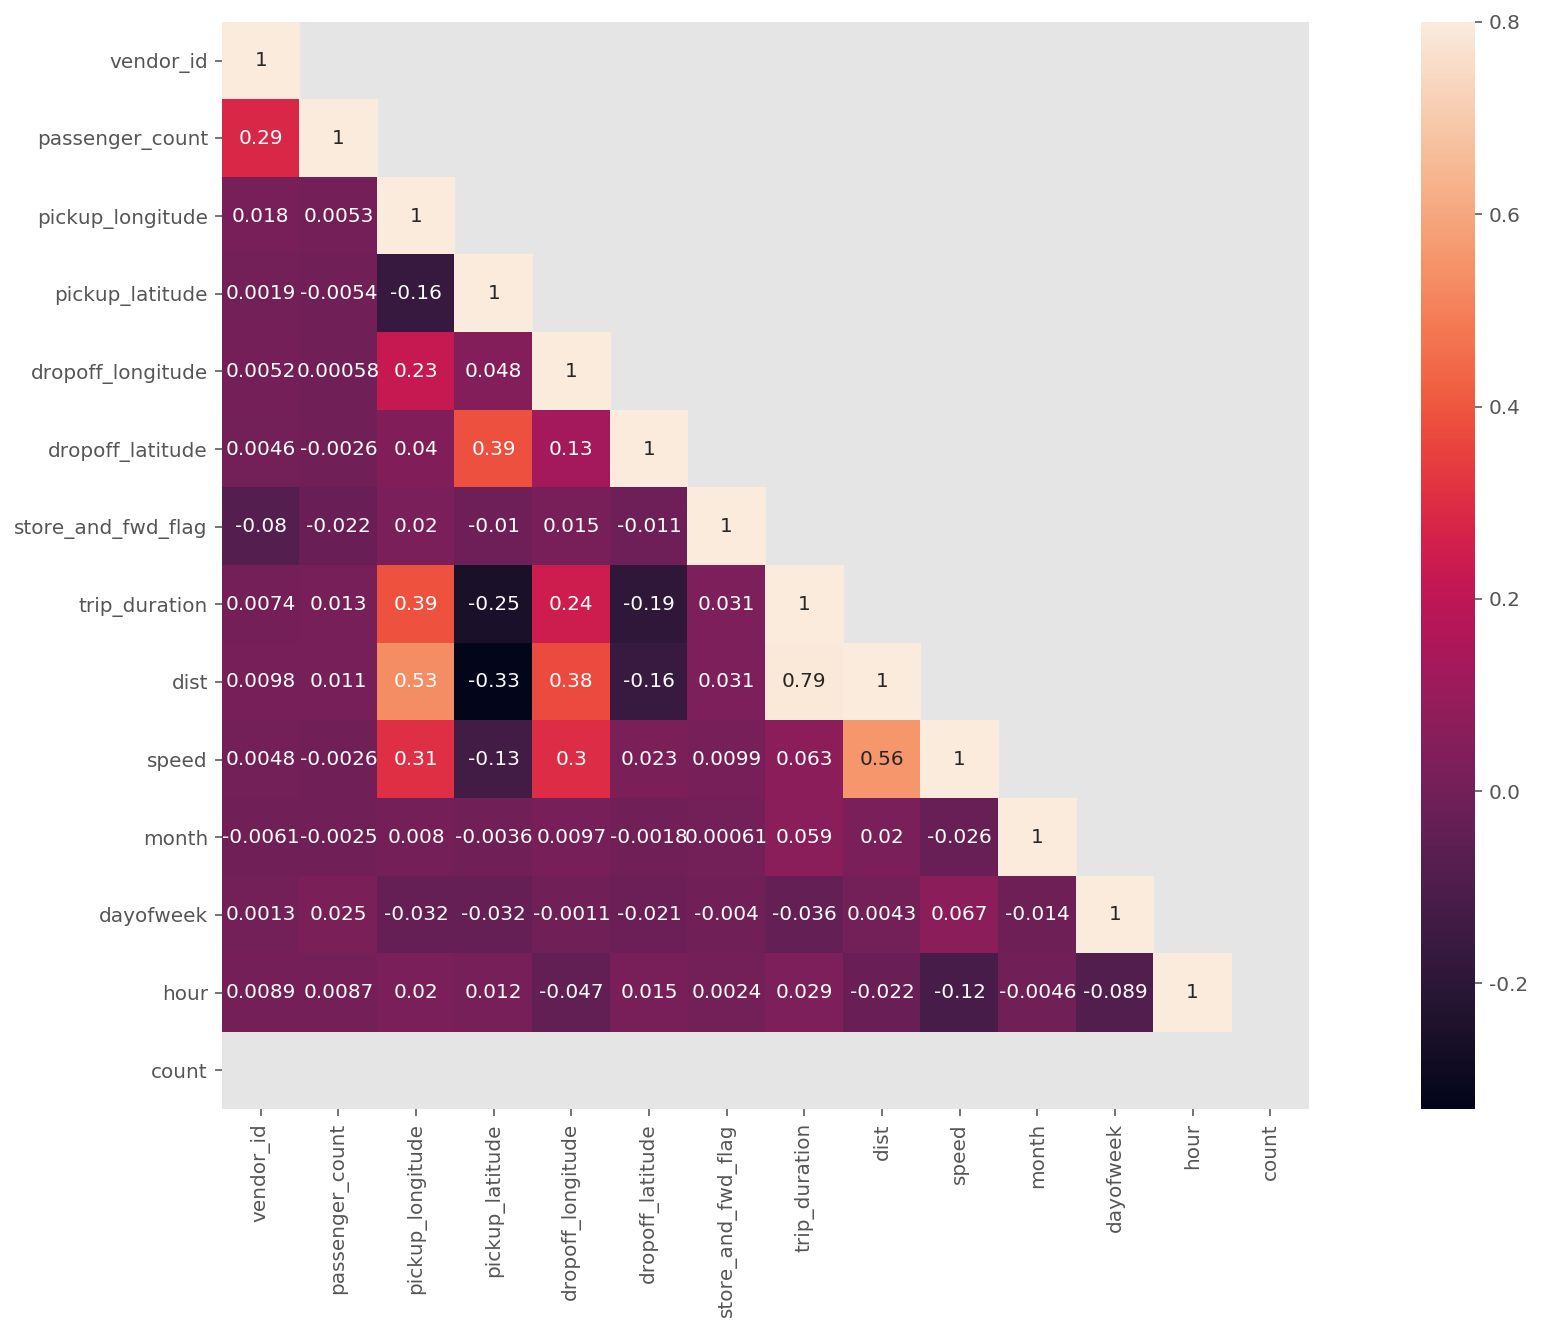

In [82]:
# 히트맵 그리기
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corrMatt, mask = mask, vmax = .8, square = True, annot = True)

plt.show()

- 변수간 상관관계가 거의 없음
- trip_duration과 상관관계가 높은건 dist, passenger_count
- passenger_count에 이상값이 있기 때문에 추후 확인이 필요

---

### 10. Test data도 바꾸기 (train과 비교)

#### 1) sotre_and_fwd_flag 변환

In [83]:
test['store_and_fwd_flag'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

#### 2) distance 생성

In [84]:
test['dist'] = \
    haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                 test['dropoff_longitude'], test['dropoff_latitude'])

#### 3) 시간 쪼개기 (pickup time 이용)

In [85]:
# pickup_datetime데이터를 datetime타입으로 변환
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"]) 

- month

In [86]:
test["month"] = test["pickup_datetime"].dt.month

- weekday

In [87]:
test["dayofweek"] = test["pickup_datetime"].dt.weekday

- hour

In [88]:
test["hour"] = test["pickup_datetime"].dt.hour

(5) 최종 데이터

In [89]:
train.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dist,speed,month,dayofweek,hour,count
1310317,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.98,40.75,-73.99,40.74,0,778,"(40.745521545410156, -73.9822006225586)",1.22,5.67,4,4,13,1
1310318,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.00,40.75,-73.97,40.80,0,655,"(40.74737930297852, -74.00094604492188)",6.05,33.23,1,6,7,1
1310319,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.96,40.77,-74.00,40.71,0,764,"(40.768798828125, -73.9591293334961)",7.82,36.85,4,4,6,1
1310320,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.98,40.75,-73.97,40.76,0,373,"(40.749061584472656, -73.9820785522461)",1.09,10.54,1,1,15,1
1310321,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.98,40.78,-73.97,40.79,0,198,"(40.7817497253418, -73.9795379638672)",1.13,20.61,4,1,14,1


### 11. Feature Engineering

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310322 entries, 0 to 1310321
Data columns (total 18 columns):
id                    1310322 non-null object
vendor_id             1310322 non-null int64
pickup_datetime       1310322 non-null datetime64[ns]
dropoff_datetime      1310322 non-null object
passenger_count       1310322 non-null int64
pickup_longitude      1310322 non-null float64
pickup_latitude       1310322 non-null float64
dropoff_longitude     1310322 non-null float64
dropoff_latitude      1310322 non-null float64
store_and_fwd_flag    1310322 non-null int64
trip_duration         1310322 non-null int64
pickup                1310322 non-null object
dist                  1310322 non-null float64
speed                 1310322 non-null float64
month                 1310322 non-null int64
dayofweek             1310322 non-null int64
hour                  1310322 non-null int64
count                 1310322 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(8), obje

In [91]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 13 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null int64
dist                  625134 non-null float64
month                 625134 non-null int64
dayofweek             625134 non-null int64
hour                  625134 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(6), object(1)
memory usage: 62.0+ MB


In [92]:
# 연속형 feature와 범주형 feature
# 연속형 feautre  = [dist, speed, hour]
# 범주형 feature = [vendor_id, passenger_count, store_and_fwd_flag, month, weekday]

# 범주형은 type을 category로 변경 (one-hot 인코딩)
categorical_feature_names = ["vendor_id", "passenger_count", "store_and_fwd_flag", "month", "dayofweek"]

In [93]:
for var in categorical_feature_names:
    train[var] = train[var].astype("category") 
    test[var] = test[var].astype("category")

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310322 entries, 0 to 1310321
Data columns (total 18 columns):
id                    1310322 non-null object
vendor_id             1310322 non-null category
pickup_datetime       1310322 non-null datetime64[ns]
dropoff_datetime      1310322 non-null object
passenger_count       1310322 non-null category
pickup_longitude      1310322 non-null float64
pickup_latitude       1310322 non-null float64
dropoff_longitude     1310322 non-null float64
dropoff_latitude      1310322 non-null float64
store_and_fwd_flag    1310322 non-null category
trip_duration         1310322 non-null int64
pickup                1310322 non-null object
dist                  1310322 non-null float64
speed                 1310322 non-null float64
month                 1310322 non-null category
dayofweek             1310322 non-null category
hour                  1310322 non-null int64
count                 1310322 non-null int64
dtypes: category(5), datetime64[ns](1)

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 13 columns):
id                    625134 non-null object
vendor_id             625134 non-null category
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null category
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null category
dist                  625134 non-null float64
month                 625134 non-null category
dayofweek             625134 non-null category
hour                  625134 non-null int64
dtypes: category(5), datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 41.1+ MB


In [96]:
feature_names = ["vendor_id", "passenger_count", "store_and_fwd_flag", "dist", "month", "dayofweek", "hour"]
feature_names

['vendor_id',
 'passenger_count',
 'store_and_fwd_flag',
 'dist',
 'month',
 'dayofweek',
 'hour']

In [97]:
x_train = train[feature_names]

print(x_train.shape)
x_train.head()

(1310322, 7)


,vendor_id,passenger_count,store_and_fwd_flag,dist,month,dayofweek,hour
0,2,1,0,1.50,3,0,17
1,1,1,0,1.80,6,6,0
2,2,1,0,6.38,1,1,11
3,2,1,0,1.48,4,2,19
4,2,1,0,1.19,3,5,13


In [98]:
x_test = test[feature_names]

print(x_test.shape)
x_test.head()

(625134, 7)


,vendor_id,passenger_count,store_and_fwd_flag,dist,month,dayofweek,hour
0,1,1,0,2.74,6,3,23
1,1,1,0,2.76,6,3,23
2,1,1,0,1.31,6,3,23
3,2,1,0,5.27,6,3,23
4,1,1,0,0.96,6,3,23


In [99]:
# 이 값을 바탕으로 test 데이터로 예측
label_name = "trip_duration"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(1310322,)


0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64

### 12.  SCORE

#### 1) RMSLE

#### RandomForest

In [100]:
from sklearn.ensemble import RandomForestRegressor

In [101]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    
    # numpy로 배열 형태 바꿔줌
    predictied_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제값에 1을 더하고 로그
    log_predict = np.log(predictied_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값 빼줌
    difference = log_predict - log_actual
    
    # difference = (log_predict - log_actual)**2
    difference = np.square(difference)
    
    # 평균 내기
    mean_difference = difference.mean()
    
    # 다시 루트 씌우기
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [102]:
max_dept_list = []

model = RandomForestRegressor(n_estimators = 100,
                              n_jobs = -1,
                              random_state = 0)

model

# n_estimators를 높일수록 예측률이 높아지지만 시간이 오래걸림

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [103]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [237]:
%time score = cross_val_score(model, x_train, y_train, cv=k_fold, scoring = rmsle_scorer)

score = score.mean() # 0에 근접할수록 좋음

print("score = {0:.5f}".format(score))

KeyboardInterrupt: 

NameError: name 'score' is not defined

### 13. Train

In [104]:
# 학습 시킴, 피팅 - 피치와 레이블을 넣어주면 알아서 학습
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [105]:
# 예측
predictions = model.predict(x_test)

print(predictions.shape)
predictions[0:10]

(625134,)


array([ 569.41,  668.06,  338.68, 1127.06,  240.17,  860.37,  839.31,
        887.34, 3042.71,  507.61])

[Text(0.5,1,'test')]

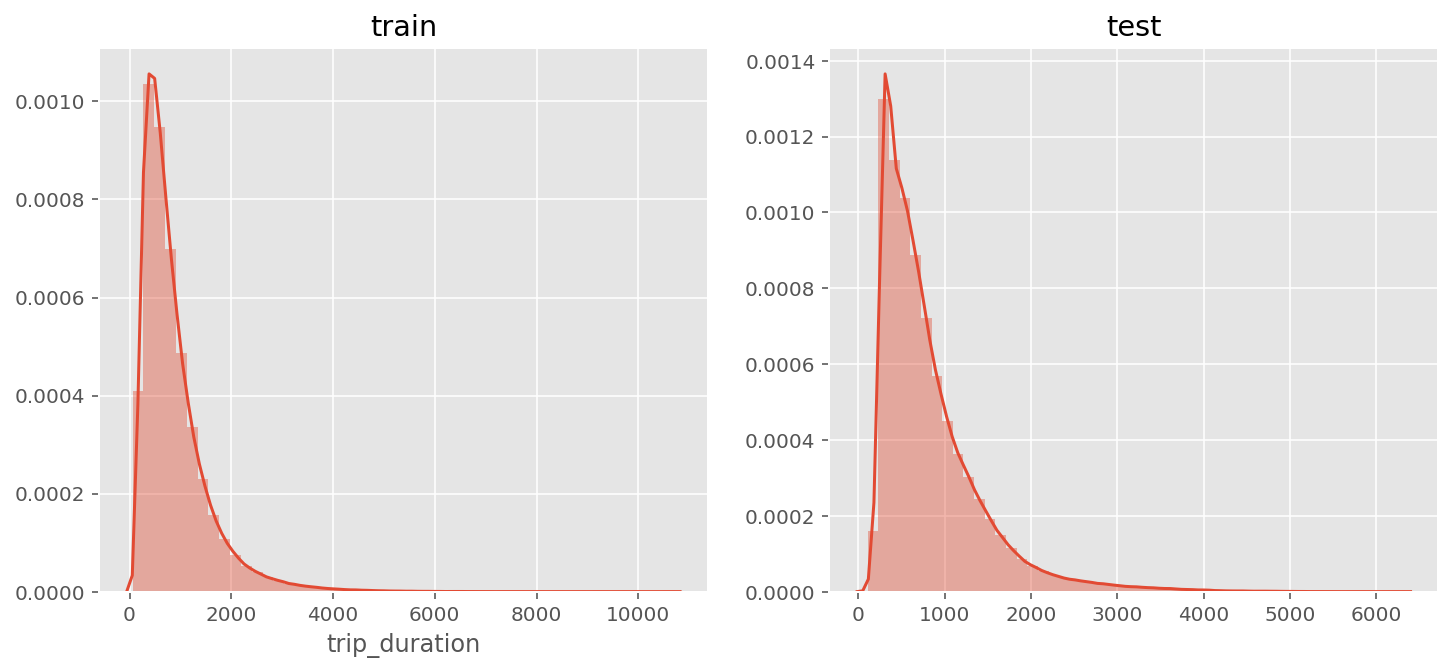

In [106]:
# 예측 데이터 시각화
fig, (ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax = ax1, bins = 50)
ax1.set(title = "train")
sns.distplot(predictions, ax = ax2, bins = 50)
ax2.set(title = "test")

### 14. Submit

In [107]:
predictions.shape

(625134,)

In [108]:
submission["trip_duration"] = predictions

print(submission.shape)
submission.head()

(625134, 2)


,id,trip_duration
0,id3004672,569.41
1,id3505355,668.06
2,id1217141,338.68
3,id2150126,1127.06
4,id1598245,240.17


In [110]:
submission.to_csv("20180227.csv", index = False)